In [1]:
import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HOME"] = "/root/autodl-tmp/cache/"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TMPDIR"]="/root/autodl-tmp/tmp"
os.environ["TORCH_HOME"]="/root/autodl-tmp/torch"
os.environ["PYTHONDONTWRITEBYTECODE"]="1"


import json
import re
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoProcessor, LlavaNextForConditionalGeneration
from peft import PeftModel
from tqdm import tqdm

# ---- Config ----
CATEGORY = "Automotive"
CANDIDATE_TYPE = "candidates_st"
BASE_MODEL_NAME = "llava-hf/llava-v1.6-mistral-7b-hf"
VISION_ADAPTER_DIR = f"./out_distilled/{CATEGORY}/vision_lora_adapter_best"
LM_ADAPTER_DIR = f"./out_finetuned/{CATEGORY}/prompt_tuning/trained_lora_adapter"
FINETUNE_OUTPUT_DIR = f"./test_out/{CATEGORY}"
#DATA_ROOT = Path("../data")
DATA_ROOT = Path("/root/autodl-tmp/lavic/data")
ITEM_META_PATH = DATA_ROOT / f"item2meta_train_{CATEGORY}.with_desc.json"
IMAGE_DIR = DATA_ROOT / "train_images" / CATEGORY
TEST_DATA_PATH = DATA_ROOT / CATEGORY / "test.jsonl"
BATCH_SIZE = 1
MAX_LENGTH = 2048
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda:1" else torch.float32

print("BASE_MODEL_NAME:", BASE_MODEL_NAME)
print("VISION_ADAPTER_DIR:", VISION_ADAPTER_DIR)
print("LM_ADAPTER_DIR:", LM_ADAPTER_DIR)
print("ITEM_META_PATH:", ITEM_META_PATH)
print("IMAGE_DIR:", IMAGE_DIR)
print("TEST_DATA_PATH:", TEST_DATA_PATH)

IMAGE_TOKENS = [
    "<ItemImageEmb1>", "<ItemImageEmb2>", "<ItemImageEmb3>",
    "<ItemImageEmb4>", "<ItemImageEmb5>"
]

BASE_MODEL_NAME: llava-hf/llava-v1.6-mistral-7b-hf
VISION_ADAPTER_DIR: ./out_distilled/Automotive/vision_lora_adapter_best
LM_ADAPTER_DIR: ./out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Automotive.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Automotive
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Automotive/test.jsonl


In [2]:
from pathlib import Path
print("cwd:", Path.cwd())
print("ITEM_META_PATH:", ITEM_META_PATH)
print("resolved:", ITEM_META_PATH.resolve())
print("exists:", ITEM_META_PATH.exists())

DATA_ROOT = Path("/root/autodl-tmp/lavic/data")

cwd: /root/autodl-tmp/lavic
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Automotive.with_desc.json
resolved: /root/autodl-tmp/lavic/data/item2meta_train_Automotive.with_desc.json
exists: True


In [3]:
def load_item_meta(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_jsonl(file_path):
    rows = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows

def evaluate_recall_at_k(recommended_ids, gt_items, k=1):
    hits = 0
    total = 0
    for rec_id, gts in zip(recommended_ids, gt_items):
        for gt in gts:
            if rec_id is not None and rec_id == gt:
                hits += 1
            total += 1
    recall = hits / total if total > 0 else 0.0
    return recall

def check_validity(file_path, model_key):
    candidates_key = f"candidates_{model_key}"
    recommended_key = f"recommended_{model_key}"
    total = 0
    valid = 0
    invalid_entries = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f, 1):
            try:
                data = json.loads(line.strip())
            except json.JSONDecodeError:
                continue
            recommended = data.get(recommended_key, None)
            candidates = data.get(candidates_key, [])
            total += 1
            if recommended in candidates:
                valid += 1
            else:
                invalid_entries.append({
                    "line_number": idx,
                    "recommended_id": recommended,
                    "candidates": candidates
                })
    validity = valid / total if total > 0 else 0.0
    return validity, invalid_entries, total

def prepare_candidate_info(candidates, item_meta, image_dir, default_image):
    candidate_info = []
    for cid in candidates:
        title = item_meta.get(cid, {}).get('title', 'No Title')
        image_path = image_dir / f"{cid}_0.jpg"
        if image_path.exists():
            image = Image.open(image_path).convert('RGB')
        else:
            image = default_image
        candidate_info.append({
            'id': cid,
            'title': title,
            'image': image
        })
    return candidate_info

CONV_CHARS_PER_TOKEN = 4

def build_prompt(conversation_text, candidates_info, max_conv_chars=None):
    if max_conv_chars is not None and len(conversation_text) > max_conv_chars:
        head_len = max_conv_chars // 2
        tail_len = max_conv_chars - head_len
        conversation_text = (
            conversation_text[:head_len]
            + "\n...[TRUNCATED]...\n"
            + conversation_text[-tail_len:]
        )
    prompt = (
        "You are an AI assistant specialized in providing personalized product recommendations based on user conversations. "
        "You are given a conversation between a user seeking recommendation (denoted by <submission>) and other users providing comments (denoted by <comment>). "
        "You are also given a set of candidate products with their IDs, titles and images formatted as \"ID: title\" followed by an image. "
        "Among the candidates, recommend the most relevant product to the seeker. "
        "Only reply with its ID, and don't say anything else.\n\n"
        f"Conversation:\n{conversation_text}\n\n"
        "Candidates:\n"
    )
    for candidate in candidates_info:
        cid = candidate['id']
        title = candidate['title']
        prompt += f"{cid}: {title}\n"
        prompt += "".join(IMAGE_TOKENS) + "\n"
    prompt += "\nAssistant:"
    return prompt

class RecommendationDataset(Dataset):
    def __init__(self, data, item_meta, image_dir, candidate_type, max_conv_chars=None):
        self.data = data
        self.item_meta = item_meta
        self.image_dir = image_dir
        self.candidate_type = candidate_type
        self.default_image = Image.new('RGB', (336, 336), color=(255, 255, 255))
        if max_conv_chars is None:
            max_conv_chars = MAX_LENGTH * CONV_CHARS_PER_TOKEN
        self.max_conv_chars = max_conv_chars

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        conversation_text = entry.get('context', '')
        gt_items = entry.get('gt_items', [])
        candidates = entry.get(self.candidate_type, [])
        candidate_info = prepare_candidate_info(candidates, self.item_meta, self.image_dir, self.default_image)
        prompt = build_prompt(conversation_text, candidate_info, max_conv_chars=self.max_conv_chars)
        images = [c['image'] for c in candidate_info]
        return {
            'prompt': prompt,
            'images': images,
            'gt_items': gt_items,
            'entry_idx': idx
        }

class DataCollatorForLLaVA:
    def __init__(self, processor, tokenizer, max_length):
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.image_token_ids = [
            self.tokenizer.convert_tokens_to_ids(tk) for tk in IMAGE_TOKENS
        ]

    def __call__(self, batch):
        prompts = [item['prompt'] for item in batch]
        images_per_sample = [item['images'] for item in batch]

        tokenized = self.tokenizer(
            prompts,
            add_special_tokens=True,
            padding=False,
            truncation=False,
        )

        input_ids_list = []
        for prompt_ids in tokenized['input_ids']:
            prompt_ids = list(prompt_ids)
            if len(prompt_ids) > self.max_length:
                bos_id = self.tokenizer.bos_token_id
                if bos_id is not None and prompt_ids[0] == bos_id:
                    prompt_ids = [bos_id] + prompt_ids[-(self.max_length - 1):]
                else:
                    prompt_ids = prompt_ids[-self.max_length:]
            input_ids_list.append(prompt_ids)

        max_len = max(len(ids) for ids in input_ids_list)
        pad_id = self.tokenizer.pad_token_id
        input_ids = torch.full((len(input_ids_list), max_len), pad_id, dtype=torch.long)
        attention_mask = torch.zeros((len(input_ids_list), max_len), dtype=torch.long)

        for i, ids in enumerate(input_ids_list):
            seq_len = len(ids)
            input_ids[i, :seq_len] = torch.tensor(ids, dtype=torch.long)
            attention_mask[i, :seq_len] = 1

        image_token_mask = torch.zeros_like(input_ids, dtype=torch.bool)
        for b_idx in range(input_ids.size(0)):
            for tid in self.image_token_ids:
                positions = (input_ids[b_idx] == tid).nonzero(as_tuple=False).squeeze(-1)
                image_token_mask[b_idx, positions] = True

        all_images = []
        for imgs in images_per_sample:
            all_images.extend(imgs)

        if all_images:
            images_processed = self.processor.image_processor(all_images, return_tensors='pt')
            images_tensor = images_processed['pixel_values']
        else:
            images_tensor = None

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'images': images_tensor,
            'image_token_mask': image_token_mask
        }


In [4]:
# Load base model + processor
base_model = LlavaNextForConditionalGeneration.from_pretrained(
    BASE_MODEL_NAME,
    torch_dtype=DTYPE,
    local_files_only=True,
).to(DEVICE)

processor = AutoProcessor.from_pretrained(BASE_MODEL_NAME, local_files_only=True)
tokenizer = processor.tokenizer

# Add special tokens
tokenizer.add_special_tokens({"additional_special_tokens": IMAGE_TOKENS})
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
tokenizer.pad_token = tokenizer.eos_token
base_model.resize_token_embeddings(len(tokenizer))

# Merge vision adapter
if VISION_ADAPTER_DIR and Path(VISION_ADAPTER_DIR).is_dir():
    base_model = PeftModel.from_pretrained(base_model, VISION_ADAPTER_DIR, local_files_only=True)
    base_model = base_model.merge_and_unload()
    base_model.to(DEVICE)

model = base_model
if LM_ADAPTER_DIR and Path(LM_ADAPTER_DIR).is_dir():
    model = PeftModel.from_pretrained(base_model, LM_ADAPTER_DIR, local_files_only=True)
    model.to(DEVICE)

model.eval()

# Data
item_meta = load_item_meta(ITEM_META_PATH)
test_data = load_jsonl(TEST_DATA_PATH)
test_ds = RecommendationDataset(test_data, item_meta, IMAGE_DIR, CANDIDATE_TYPE)
collator = DataCollatorForLLaVA(processor, tokenizer, MAX_LENGTH)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: x)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
### Batch evaluate all categories with the last cell's logic
import os
from sentence_transformers import SentenceTransformer
import torch.nn as nn

CATEGORY_LIST = [
    "amazon_home",
    "amazon_fashion",
    "all_beauty",
    "Appliances",
    "Arts_Crafts_and_Sewing",
    "Automotive",
    "Baby_Products",
    "Books",
    "CDs_and_Vinyl",
    "Cell_Phones_and_Accessories",
    "Digital_Music",
    "Electronics",
    "Grocery_and_Gourmet_Food",
    "Handmade_Products",
    "Health",
    "Industrial_and_Scientific",
    "Kindle_Store",
    "Movies_and_TV",
    "Musical_Instruments",
    "Office_Products",
    "Patio_Lawn_and_Garden",
    "Pet_Supplies",
    "Software",
    "Sports_and_Outdoors",
    "Toys_and_Games",
    "Video_Games",
]

# Force offline to avoid any downloads
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_DATASETS_OFFLINE"] = "1"

# Gate router paths (from MoLoRA_Gating_lllm (1).ipynb)
GATE_CKPT_DIR = Path("/root/autodl-tmp/cache/llmSimpleRouter")
GATE_ROUTER_PATH = GATE_CKPT_DIR / "gate_router.pt"
GATE_LABEL_MAP_PATH = GATE_CKPT_DIR / "gate_label_mapping.json"
ST_MAX_LENGTH = 256
ST_MODEL_NAME = "/root/autodl-tmp/cache/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf"
if not Path(ST_MODEL_NAME).is_dir():
    raise FileNotFoundError(f"ST model path not found: {ST_MODEL_NAME}")
print("[DEBUG] ST_MODEL_NAME:", ST_MODEL_NAME)

TOPK = 3
CONF_THRESHOLD = 0.0  # set >0 to drop low-conf router picks
FALLBACK_CATEGORY = None  # None => first available

# Absolute path templates (CATEGORY will be replaced)
VISION_TEMPLATE = "/root/autodl-tmp/lavic/src/out_distilled/{category}/lora_adapter_best"
LM_TEMPLATE = "/root/autodl-tmp/lavic/src/out_finetuned/{category}/prompt_tuning/trained_lora_adapter"

print("[DEBUG] Offline mode: HF_HUB_OFFLINE=1, TRANSFORMERS_OFFLINE=1")
print("[DEBUG] VISION_TEMPLATE:", VISION_TEMPLATE)
print("[DEBUG] LM_TEMPLATE:", LM_TEMPLATE)

class SimpleRouter(nn.Module):
    def __init__(self, hidden_size, num_adapters):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(hidden_size, num_adapters))
    def forward(self, x):
        return self.net(x)

if BATCH_SIZE != 1:
    raise ValueError("Top-3 router evaluation assumes BATCH_SIZE=1 (image placement).")

if not GATE_ROUTER_PATH.exists() or not GATE_LABEL_MAP_PATH.exists():
    raise FileNotFoundError("Missing gate router or label mapping.")

with GATE_LABEL_MAP_PATH.open("r", encoding="utf-8") as f:
    label_map = json.load(f)
sorted_indices = sorted(int(i) for i in label_map.keys())
gate_categories = [label_map[str(i)] for i in sorted_indices]
print("[DEBUG] Router categories:", len(gate_categories))

st_model = SentenceTransformer(ST_MODEL_NAME, device=DEVICE, cache_folder=os.environ.get("HF_HOME"), local_files_only=True)
st_model.max_seq_length = ST_MAX_LENGTH
embed_dim = st_model.get_sentence_embedding_dimension()
print("[DEBUG] ST model dim:", embed_dim)

router = SimpleRouter(hidden_size=embed_dim, num_adapters=len(gate_categories)).to(DEVICE).to(DTYPE)
router.load_state_dict(torch.load(GATE_ROUTER_PATH, map_location=DEVICE))
router.eval()
print("[DEBUG] Router loaded")

# Discover adapter pairs per category
category_to_adapters = {}
for cat in gate_categories:
    v_dir = Path(VISION_TEMPLATE.format(category=cat))
    if v_dir.is_dir():
        category_to_adapters[cat] = {
            "vision": str(v_dir),
        }
print("[DEBUG] Adapter pairs found:", len(category_to_adapters))

if not category_to_adapters:
    raise RuntimeError("No valid (vision+lm) adapter pairs found.")

if FALLBACK_CATEGORY is None or FALLBACK_CATEGORY not in category_to_adapters:
    FALLBACK_CATEGORY = sorted(category_to_adapters.keys())[0]
print("[DEBUG] FALLBACK_CATEGORY:", FALLBACK_CATEGORY)


def evaluate_category(category: str) -> None:
    global CATEGORY, ITEM_META_PATH, IMAGE_DIR, TEST_DATA_PATH, FINETUNE_OUTPUT_DIR

    CATEGORY = category
    LM_FIXED_DIR = Path(LM_TEMPLATE.format(category=CATEGORY))
    if not LM_FIXED_DIR.is_dir():
        raise FileNotFoundError(f"LM LoRA not found for CATEGORY={CATEGORY}: {LM_FIXED_DIR}")
    print("[DEBUG] LM_FIXED_DIR:", LM_FIXED_DIR)
    ITEM_META_PATH = DATA_ROOT / f"item2meta_train_{CATEGORY}.with_desc.json"
    IMAGE_DIR = DATA_ROOT / "train_images" / CATEGORY
    TEST_DATA_PATH = DATA_ROOT / CATEGORY / "test.jsonl"
    FINETUNE_OUTPUT_DIR = f"./slora_test_out/{CATEGORY}"

    print("\n========================================")
    print(f"[DEBUG] Start category: {CATEGORY}")
    print("ITEM_META_PATH:", ITEM_META_PATH)
    print("IMAGE_DIR:", IMAGE_DIR)
    print("TEST_DATA_PATH:", TEST_DATA_PATH)
    print("FINETUNE_OUTPUT_DIR:", FINETUNE_OUTPUT_DIR)
    print("========================================")

    item_meta = load_item_meta(ITEM_META_PATH)
    test_data = load_jsonl(TEST_DATA_PATH)
    test_ds = RecommendationDataset(test_data, item_meta, IMAGE_DIR, CANDIDATE_TYPE)
    collator = DataCollatorForLLaVA(processor, tokenizer, MAX_LENGTH)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: x)

    # Pass 1: route top-3 for each sample
    sample_top3 = []
    category_to_samples = {cat: [] for cat in category_to_adapters.keys()}

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc=f"Routing {CATEGORY}", unit="batch"), 1):
            entry_idx = batch[0].get('entry_idx', None)
            if entry_idx is None:
                raise ValueError("Missing entry_idx in batch.")
            context_text = test_data[entry_idx].get('context', '').strip()
            emb = st_model.encode([context_text], convert_to_tensor=True, device=DEVICE, show_progress_bar=False)
            emb = emb.to(DTYPE)
            logits = router(emb)
            probs = torch.softmax(logits, dim=-1)
            top_probs, top_idx = torch.topk(probs, k=min(TOPK, probs.shape[-1]), dim=-1)

            top_cats = []
            top_confs = []
            for i in range(top_idx.shape[-1]):
                idx = int(top_idx[0, i].item())
                cat = label_map.get(str(idx), None)
                conf = float(top_probs[0, i].item())
                if conf < CONF_THRESHOLD or cat not in category_to_adapters:
                    continue
                top_cats.append(cat)
                top_confs.append(conf)

            if not top_cats:
                top_cats = [FALLBACK_CATEGORY]
                top_confs = [1.0]

            sample_top3.append({
                "top_cats": top_cats,
                "top_confs": top_confs,
            })
            for cat in top_cats:
                category_to_samples[cat].append(entry_idx)

    print(f"[DEBUG] Routing complete for {CATEGORY}. Samples: {len(sample_top3)}")

    # Prepare aggregation containers
    recommended_ids = [None] * len(test_data)
    responses = [""] * len(test_data)
    ground_truths = [entry.get('gt_items', []) for entry in test_data]
    selected_categories = [None] * len(test_data)
    selected_confs = [None] * len(test_data)
    selected_top3 = [None] * len(test_data)
    selected_top3_confs = [None] * len(test_data)
    selected_top3_recs = [None] * len(test_data)

    score_maps = [None] * len(test_data)
    resp_maps = [None] * len(test_data)

    # Pass 2: process per category (load once)
    for cat, sample_ids in category_to_samples.items():
        if not sample_ids:
            continue

        v_dir = category_to_adapters[cat]["vision"]
        l_dir = LM_FIXED_DIR
        print(f"[DEBUG] Load model for {cat}:\n  vision={v_dir}\n  lm={l_dir}\n  samples={len(sample_ids)}")

        base = LlavaNextForConditionalGeneration.from_pretrained(
            BASE_MODEL_NAME,
            torch_dtype=DTYPE,
            local_files_only=True,
        ).to(DEVICE)

        # merge vision adapter
        base = PeftModel.from_pretrained(base, v_dir, local_files_only=True)
        base = base.merge_and_unload()
        base = base.to(DEVICE)

        # apply LM adapter
        model = PeftModel.from_pretrained(base, l_dir, local_files_only=True).to(DEVICE)
        model.eval()

        with torch.no_grad():
            for entry_idx in tqdm(sample_ids, desc=f"Evaluating {CATEGORY}->{cat}", unit="sample"):
                batch = [test_ds[entry_idx]]
                inputs = collator(batch)
                input_ids = inputs['input_ids'].to(DEVICE)
                attention_mask = inputs['attention_mask'].to(DEVICE)
                image_token_mask = inputs['image_token_mask'].to(DEVICE)
                images = inputs['images']

                inputs_embeds = model.language_model.get_input_embeddings()(input_ids)
                if images is not None:
                    images = images.to(DEVICE, dtype=DTYPE)
                    if images.dim() == 5:
                        b_img, num_views, c, h, w = images.shape
                        images_reshaped = images.view(-1, c, h, w)
                    else:
                        num_views = 1
                        images_reshaped = images
                    vision_outputs = model.vision_tower(images_reshaped, return_dict=False)
                    cls_states = vision_outputs[0][:, 0, :]
                    total_patches = cls_states.shape[0]
                    expected_images = input_ids.size(0) * num_views
                    if total_patches > expected_images:
                        patches_per_image = total_patches // expected_images
                        if total_patches % expected_images == 0 and patches_per_image > 1:
                            cls_states = cls_states.view(expected_images, patches_per_image, -1).mean(dim=1)
                    cls_states = cls_states.reshape(input_ids.size(0), num_views, -1)
                    cls_states = model.multi_modal_projector(cls_states)
                    for b_idx in range(input_ids.size(0)):
                        positions = torch.nonzero(image_token_mask[b_idx], as_tuple=False).squeeze(-1)
                        pos_count = min(len(positions), num_views)
                        for i in range(pos_count):
                            col = positions[i].item()
                            inputs_embeds[b_idx, col, :] = cls_states[b_idx, i, :]

                generated_ids = model.generate(
                    inputs_embeds=inputs_embeds,
                    attention_mask=attention_mask,
                    max_new_tokens=10,
                    num_beams=1,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id,
                )
                generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
                match = re.findall(r'\bB[A-Z0-9]{9}\b', generated_texts[0].strip())
                rec_id = match[0][:10] if match else None

                # init per-sample aggregation
                if score_maps[entry_idx] is None:
                    score_maps[entry_idx] = {}
                    resp_maps[entry_idx] = {}
                    selected_top3[entry_idx] = sample_top3[entry_idx]["top_cats"]
                    selected_top3_confs[entry_idx] = sample_top3[entry_idx]["top_confs"]
                    selected_categories[entry_idx] = sample_top3[entry_idx]["top_cats"][0]
                    selected_confs[entry_idx] = sample_top3[entry_idx]["top_confs"][0]

                # weight by router confidence for this category
                top_cats = sample_top3[entry_idx]["top_cats"]
                top_confs = sample_top3[entry_idx]["top_confs"]
                conf = top_confs[top_cats.index(cat)] if cat in top_cats else 0.0

                score_maps[entry_idx][rec_id] = score_maps[entry_idx].get(rec_id, 0.0) + conf
                if rec_id not in resp_maps[entry_idx]:
                    resp_maps[entry_idx][rec_id] = generated_texts[0]

        del model
        del base
        torch.cuda.empty_cache()

    # Final fusion per sample
    for i in range(len(test_data)):
        if score_maps[i] is None or not score_maps[i]:
            recommended_ids[i] = None
            responses[i] = ""
            selected_top3_recs[i] = []
            continue

        best_rec_id = max(score_maps[i].items(), key=lambda kv: kv[1])[0]
        recommended_ids[i] = best_rec_id
        responses[i] = resp_maps[i].get(best_rec_id, "")
        selected_top3_recs[i] = [None] * len(selected_top3[i])

    recall = evaluate_recall_at_k(recommended_ids, ground_truths, k=1)
    print(f"[Test] Recall@1 ({CATEGORY}): {recall:.4f}")

    model_key = 'st' if CANDIDATE_TYPE == 'candidates_st' else 'gpt_large'
    if model_key == 'st':
        recommended_field = 'recommended_st'
        response_field = 'response_st'
    else:
        recommended_field = f"recommended_{model_key}"
        response_field = f"response_{model_key}"

    out_file_name = f"test_results_{CANDIDATE_TYPE}_router_top3_vl.jsonl"
    output_file_path = Path(FINETUNE_OUTPUT_DIR) / out_file_name
    output_file_path.parent.mkdir(parents=True, exist_ok=True)

    with output_file_path.open('w', encoding='utf-8') as f:
        for entry, rec_id, resp, sel_cat, sel_conf, top3, top3_confs in zip(
            test_data, recommended_ids, responses, selected_categories, selected_confs,
            selected_top3, selected_top3_confs
        ):
            entry[recommended_field] = rec_id
            entry[response_field] = resp
            entry['selected_category'] = sel_cat
            entry['selected_confidence'] = sel_conf
            entry['router_top3'] = top3
            entry['router_top3_confidences'] = top3_confs
            json.dump(entry, f, ensure_ascii=False)
            f.write('\n')

    validity, invalid_entries, total_count = check_validity(output_file_path, model_key)
    print(f"Validity@1 ({CATEGORY}): {validity:.4f}, invalid entries: {len(invalid_entries)} / {total_count}")
    print(f"Test details saved to {output_file_path}")



[DEBUG] ST_MODEL_NAME: /root/autodl-tmp/cache/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf
[DEBUG] Offline mode: HF_HUB_OFFLINE=1, TRANSFORMERS_OFFLINE=1
[DEBUG] VISION_TEMPLATE: /root/autodl-tmp/lavic/src/out_distilled/{category}/lora_adapter_best
[DEBUG] LM_TEMPLATE: /root/autodl-tmp/lavic/src/out_finetuned/{category}/prompt_tuning/trained_lora_adapter
[DEBUG] Router categories: 26
[DEBUG] ST model dim: 384
[DEBUG] Router loaded
[DEBUG] Adapter pairs found: 26
[DEBUG] FALLBACK_CATEGORY: Appliances


In [14]:
evaluate_category("Automotive")

[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Automotive
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Automotive.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Automotive
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Automotive/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Automotive


Routing Automotive: 100%|██████████| 152/152 [00:01<00:00, 94.86batch/s]

[DEBUG] Routing complete for Automotive. Samples: 152
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=7


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Appliances: 100%|██████████| 7/7 [00:04<00:00,  1.58sample/s]

[DEBUG] Load model for Arts_Crafts_and_Sewing:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Arts_Crafts_and_Sewing/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Arts_Crafts_and_Sewing: 100%|██████████| 3/3 [00:01<00:00,  1.63sample/s]

[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=143


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Automotive: 100%|██████████| 143/143 [01:25<00:00,  1.66sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Baby_Products: 100%|██████████| 2/2 [00:01<00:00,  1.73sample/s]

[DEBUG] Load model for CDs_and_Vinyl:
  vision=/root/autodl-tmp/lavic/src/out_distilled/CDs_and_Vinyl/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->CDs_and_Vinyl: 100%|██████████| 2/2 [00:01<00:00,  1.73sample/s]

[DEBUG] Load model for Cell_Phones_and_Accessories:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Cell_Phones_and_Accessories/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=15


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Cell_Phones_and_Accessories: 100%|██████████| 15/15 [00:09<00:00,  1.60sample/s]

[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=40


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Electronics: 100%|██████████| 40/40 [00:24<00:00,  1.66sample/s]

[DEBUG] Load model for Grocery_and_Gourmet_Food:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Grocery_and_Gourmet_Food/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Grocery_and_Gourmet_Food: 100%|██████████| 1/1 [00:00<00:00,  1.79sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Handmade_Products: 100%|██████████| 1/1 [00:00<00:00,  1.53sample/s]

[DEBUG] Load model for Health:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Health/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Health: 100%|██████████| 2/2 [00:01<00:00,  1.63sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=34


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Industrial_and_Scientific: 100%|██████████| 34/34 [00:20<00:00,  1.66sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Kindle_Store: 100%|██████████| 1/1 [00:00<00:00,  1.66sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Movies_and_TV: 100%|██████████| 1/1 [00:00<00:00,  1.61sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=9


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Musical_Instruments: 100%|██████████| 9/9 [00:05<00:00,  1.60sample/s]


[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Office_Products: 100%|██████████| 5/5 [00:03<00:00,  1.59sample/s]

[DEBUG] Load model for Patio_Lawn_and_Garden:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Patio_Lawn_and_Garden/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Patio_Lawn_and_Garden: 100%|██████████| 1/1 [00:00<00:00,  1.60sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=9


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Pet_Supplies: 100%|██████████| 9/9 [00:05<00:00,  1.66sample/s]

[DEBUG] Load model for Software:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Software/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Software: 100%|██████████| 2/2 [00:01<00:00,  1.61sample/s]

[DEBUG] Load model for Sports_and_Outdoors:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Sports_and_Outdoors/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Sports_and_Outdoors: 100%|██████████| 2/2 [00:01<00:00,  1.76sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->Video_Games: 100%|██████████| 3/3 [00:01<00:00,  1.51sample/s]

[DEBUG] Load model for all_beauty:
  vision=/root/autodl-tmp/lavic/src/out_distilled/all_beauty/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=64


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->all_beauty: 100%|██████████| 64/64 [00:38<00:00,  1.68sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=25


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->amazon_fashion: 100%|██████████| 25/25 [00:18<00:00,  1.39sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Automotive/prompt_tuning/trained_lora_adapter
  samples=84


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Automotive->amazon_home: 100%|██████████| 84/84 [01:07<00:00,  1.25sample/s]

[Test] Recall@1 (Automotive): 0.0987
Validity@1 (Automotive): 1.0000, invalid entries: 0 / 152
Test details saved to slora_test_out/Automotive/test_results_candidates_st_router_top3_vl.jsonl


In [15]:
evaluate_category("all_beauty")

[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: all_beauty
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_all_beauty.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/all_beauty
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/all_beauty/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/all_beauty


Routing all_beauty: 100%|██████████| 772/772 [00:11<00:00, 65.94batch/s]


[DEBUG] Routing complete for all_beauty. Samples: 772
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Appliances: 100%|██████████| 4/4 [00:03<00:00,  1.17sample/s]

[DEBUG] Load model for Arts_Crafts_and_Sewing:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Arts_Crafts_and_Sewing/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=29


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Arts_Crafts_and_Sewing: 100%|██████████| 29/29 [00:23<00:00,  1.25sample/s]

[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=58


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Automotive: 100%|██████████| 58/58 [00:48<00:00,  1.21sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=22


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Baby_Products: 100%|██████████| 22/22 [00:18<00:00,  1.19sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Books: 100%|██████████| 1/1 [00:00<00:00,  1.20sample/s]

[DEBUG] Load model for CDs_and_Vinyl:
  vision=/root/autodl-tmp/lavic/src/out_distilled/CDs_and_Vinyl/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=8


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->CDs_and_Vinyl: 100%|██████████| 8/8 [00:06<00:00,  1.32sample/s]

[DEBUG] Load model for Cell_Phones_and_Accessories:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Cell_Phones_and_Accessories/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Cell_Phones_and_Accessories: 100%|██████████| 3/3 [00:02<00:00,  1.11sample/s]


[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=12


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Electronics: 100%|██████████| 12/12 [00:10<00:00,  1.13sample/s]

[DEBUG] Load model for Grocery_and_Gourmet_Food:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Grocery_and_Gourmet_Food/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=52


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Grocery_and_Gourmet_Food: 100%|██████████| 52/52 [00:41<00:00,  1.24sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=15


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Handmade_Products: 100%|██████████| 15/15 [00:12<00:00,  1.23sample/s]

[DEBUG] Load model for Health:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Health/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=367


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Health: 100%|██████████| 367/367 [04:40<00:00,  1.31sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=32


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Industrial_and_Scientific: 100%|██████████| 32/32 [00:21<00:00,  1.48sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=14


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Kindle_Store: 100%|██████████| 14/14 [00:11<00:00,  1.20sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Movies_and_TV: 100%|██████████| 6/6 [00:04<00:00,  1.31sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Musical_Instruments: 100%|██████████| 3/3 [00:02<00:00,  1.09sample/s]

[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=16


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Office_Products: 100%|██████████| 16/16 [00:12<00:00,  1.26sample/s]


[DEBUG] Load model for Patio_Lawn_and_Garden:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Patio_Lawn_and_Garden/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=10


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Patio_Lawn_and_Garden: 100%|██████████| 10/10 [00:07<00:00,  1.26sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=38


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Pet_Supplies: 100%|██████████| 38/38 [00:30<00:00,  1.25sample/s]

[DEBUG] Load model for Software:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Software/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Software: 100%|██████████| 1/1 [00:00<00:00,  1.06sample/s]

[DEBUG] Load model for Sports_and_Outdoors:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Sports_and_Outdoors/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=24


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Sports_and_Outdoors: 100%|██████████| 24/24 [00:19<00:00,  1.21sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Toys_and_Games: 100%|██████████| 6/6 [00:04<00:00,  1.29sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=38


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->Video_Games: 100%|██████████| 38/38 [00:27<00:00,  1.39sample/s]

[DEBUG] Load model for all_beauty:
  vision=/root/autodl-tmp/lavic/src/out_distilled/all_beauty/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=739


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->all_beauty: 100%|██████████| 739/739 [07:37<00:00,  1.62sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=374


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->amazon_fashion: 100%|██████████| 374/374 [03:52<00:00,  1.61sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/all_beauty/prompt_tuning/trained_lora_adapter
  samples=444


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating all_beauty->amazon_home: 100%|██████████| 444/444 [06:02<00:00,  1.23sample/s]

[Test] Recall@1 (all_beauty): 0.1067
Validity@1 (all_beauty): 0.9883, invalid entries: 9 / 772
Test details saved to slora_test_out/all_beauty/test_results_candidates_st_router_top3_vl.jsonl


In [16]:
evaluate_category("amazon_fashion")

[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: amazon_fashion
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_amazon_fashion.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/amazon_fashion
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/amazon_fashion/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/amazon_fashion


Routing amazon_fashion: 100%|██████████| 826/826 [00:11<00:00, 71.00batch/s]

[DEBUG] Routing complete for amazon_fashion. Samples: 826
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Appliances: 100%|██████████| 3/3 [00:02<00:00,  1.46sample/s]

[DEBUG] Load model for Arts_Crafts_and_Sewing:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Arts_Crafts_and_Sewing/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=170


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Arts_Crafts_and_Sewing: 100%|██████████| 170/170 [01:54<00:00,  1.48sample/s]


[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=34


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Automotive: 100%|██████████| 34/34 [00:25<00:00,  1.31sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=25


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Baby_Products: 100%|██████████| 25/25 [00:20<00:00,  1.25sample/s]

[DEBUG] Load model for CDs_and_Vinyl:
  vision=/root/autodl-tmp/lavic/src/out_distilled/CDs_and_Vinyl/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=24


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->CDs_and_Vinyl: 100%|██████████| 24/24 [00:18<00:00,  1.29sample/s]


[DEBUG] Load model for Cell_Phones_and_Accessories:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Cell_Phones_and_Accessories/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=30


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Cell_Phones_and_Accessories: 100%|██████████| 30/30 [00:22<00:00,  1.31sample/s]

[DEBUG] Load model for Digital_Music:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Digital_Music/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Digital_Music: 100%|██████████| 1/1 [00:00<00:00,  1.63sample/s]

[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=26


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Electronics: 100%|██████████| 26/26 [00:15<00:00,  1.65sample/s]


[DEBUG] Load model for Grocery_and_Gourmet_Food:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Grocery_and_Gourmet_Food/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=10


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Grocery_and_Gourmet_Food: 100%|██████████| 10/10 [00:07<00:00,  1.27sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=90


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Handmade_Products: 100%|██████████| 90/90 [01:12<00:00,  1.25sample/s]

[DEBUG] Load model for Health:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Health/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=11


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Health: 100%|██████████| 11/11 [00:09<00:00,  1.20sample/s]


[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=24


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Industrial_and_Scientific: 100%|██████████| 24/24 [00:18<00:00,  1.28sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=21


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Kindle_Store: 100%|██████████| 21/21 [00:16<00:00,  1.25sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=32


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Movies_and_TV: 100%|██████████| 32/32 [00:24<00:00,  1.29sample/s]


[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=42


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Musical_Instruments: 100%|██████████| 42/42 [00:25<00:00,  1.64sample/s]

[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=78


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Office_Products: 100%|██████████| 78/78 [00:42<00:00,  1.83sample/s]

[DEBUG] Load model for Patio_Lawn_and_Garden:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Patio_Lawn_and_Garden/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Patio_Lawn_and_Garden: 100%|██████████| 3/3 [00:01<00:00,  1.66sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=19


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Pet_Supplies: 100%|██████████| 19/19 [00:11<00:00,  1.70sample/s]

[DEBUG] Load model for Software:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Software/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Software: 100%|██████████| 2/2 [00:01<00:00,  1.53sample/s]

[DEBUG] Load model for Sports_and_Outdoors:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Sports_and_Outdoors/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=230


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Sports_and_Outdoors: 100%|██████████| 230/230 [02:10<00:00,  1.76sample/s]


[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=47


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Toys_and_Games: 100%|██████████| 47/47 [00:26<00:00,  1.80sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=56


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->Video_Games: 100%|██████████| 56/56 [00:32<00:00,  1.72sample/s]

[DEBUG] Load model for all_beauty:
  vision=/root/autodl-tmp/lavic/src/out_distilled/all_beauty/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=450


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->all_beauty: 100%|██████████| 450/450 [04:21<00:00,  1.72sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=781


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->amazon_fashion: 100%|██████████| 781/781 [07:27<00:00,  1.74sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_fashion/prompt_tuning/trained_lora_adapter
  samples=269


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_fashion->amazon_home: 100%|██████████| 269/269 [02:32<00:00,  1.76sample/s]

[Test] Recall@1 (amazon_fashion): 0.1242
Validity@1 (amazon_fashion): 0.9879, invalid entries: 10 / 826
Test details saved to slora_test_out/amazon_fashion/test_results_candidates_st_router_top3_vl.jsonl


In [17]:
evaluate_category("amazon_home")

[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: amazon_home
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_amazon_home.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/amazon_home
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/amazon_home/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/amazon_home


Routing amazon_home: 100%|██████████| 372/372 [00:04<00:00, 77.37batch/s]


[DEBUG] Routing complete for amazon_home. Samples: 372
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=52


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Appliances: 100%|██████████| 52/52 [00:30<00:00,  1.70sample/s]

[DEBUG] Load model for Arts_Crafts_and_Sewing:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Arts_Crafts_and_Sewing/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=29


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Arts_Crafts_and_Sewing: 100%|██████████| 29/29 [00:17<00:00,  1.70sample/s]

[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=32


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Automotive: 100%|██████████| 32/32 [00:19<00:00,  1.67sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=26


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Baby_Products: 100%|██████████| 26/26 [00:15<00:00,  1.68sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Books: 100%|██████████| 3/3 [00:01<00:00,  1.62sample/s]

[DEBUG] Load model for CDs_and_Vinyl:
  vision=/root/autodl-tmp/lavic/src/out_distilled/CDs_and_Vinyl/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->CDs_and_Vinyl: 100%|██████████| 5/5 [00:02<00:00,  1.72sample/s]

[DEBUG] Load model for Cell_Phones_and_Accessories:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Cell_Phones_and_Accessories/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Cell_Phones_and_Accessories: 100%|██████████| 3/3 [00:01<00:00,  1.72sample/s]

[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=48


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Electronics: 100%|██████████| 48/48 [00:28<00:00,  1.67sample/s]

[DEBUG] Load model for Grocery_and_Gourmet_Food:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Grocery_and_Gourmet_Food/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=55


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Grocery_and_Gourmet_Food: 100%|██████████| 55/55 [00:32<00:00,  1.71sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=17


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Handmade_Products: 100%|██████████| 17/17 [00:10<00:00,  1.67sample/s]

[DEBUG] Load model for Health:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Health/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=19


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Health: 100%|██████████| 19/19 [00:11<00:00,  1.67sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=79


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Industrial_and_Scientific: 100%|██████████| 79/79 [00:46<00:00,  1.71sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=10


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Kindle_Store: 100%|██████████| 10/10 [00:05<00:00,  1.69sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Movies_and_TV: 100%|██████████| 6/6 [00:03<00:00,  1.72sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=12


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Musical_Instruments: 100%|██████████| 12/12 [00:07<00:00,  1.71sample/s]

[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=28


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Office_Products: 100%|██████████| 28/28 [00:16<00:00,  1.68sample/s]

[DEBUG] Load model for Patio_Lawn_and_Garden:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Patio_Lawn_and_Garden/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=29


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Patio_Lawn_and_Garden: 100%|██████████| 29/29 [00:17<00:00,  1.68sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=51


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Pet_Supplies: 100%|██████████| 51/51 [00:30<00:00,  1.67sample/s]


[DEBUG] Load model for Sports_and_Outdoors:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Sports_and_Outdoors/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=16


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Sports_and_Outdoors: 100%|██████████| 16/16 [00:09<00:00,  1.68sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=18


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Toys_and_Games: 100%|██████████| 18/18 [00:10<00:00,  1.71sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=16


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->Video_Games: 100%|██████████| 16/16 [00:09<00:00,  1.64sample/s]


[DEBUG] Load model for all_beauty:
  vision=/root/autodl-tmp/lavic/src/out_distilled/all_beauty/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=137


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->all_beauty: 100%|██████████| 137/137 [01:21<00:00,  1.69sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=112


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->amazon_fashion: 100%|██████████| 112/112 [01:07<00:00,  1.67sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/amazon_home/prompt_tuning/trained_lora_adapter
  samples=313


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating amazon_home->amazon_home: 100%|██████████| 313/313 [03:07<00:00,  1.67sample/s]

[Test] Recall@1 (amazon_home): 0.2695
Validity@1 (amazon_home): 1.0000, invalid entries: 0 / 372
Test details saved to slora_test_out/amazon_home/test_results_candidates_st_router_top3_vl.jsonl


In [18]:
evaluate_category("Books")

[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Books
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Books.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Books
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Books/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Books


Routing Books: 100%|██████████| 472/472 [00:05<00:00, 79.68batch/s]


[DEBUG] Routing complete for Books. Samples: 472
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Appliances: 100%|██████████| 1/1 [00:00<00:00,  1.81sample/s]

[DEBUG] Load model for Arts_Crafts_and_Sewing:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Arts_Crafts_and_Sewing/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Arts_Crafts_and_Sewing: 100%|██████████| 2/2 [00:01<00:00,  1.69sample/s]


[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Automotive: 100%|██████████| 1/1 [00:00<00:00,  1.75sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=14


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Baby_Products: 100%|██████████| 14/14 [00:08<00:00,  1.63sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=466


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Books: 100%|██████████| 466/466 [05:12<00:00,  1.49sample/s]


[DEBUG] Load model for CDs_and_Vinyl:
  vision=/root/autodl-tmp/lavic/src/out_distilled/CDs_and_Vinyl/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->CDs_and_Vinyl: 100%|██████████| 6/6 [00:04<00:00,  1.33sample/s]

[DEBUG] Load model for Cell_Phones_and_Accessories:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Cell_Phones_and_Accessories/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Cell_Phones_and_Accessories: 100%|██████████| 2/2 [00:01<00:00,  1.25sample/s]

[DEBUG] Load model for Digital_Music:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Digital_Music/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Digital_Music: 100%|██████████| 4/4 [00:03<00:00,  1.22sample/s]


[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=29


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Electronics: 100%|██████████| 29/29 [00:22<00:00,  1.28sample/s]

[DEBUG] Load model for Grocery_and_Gourmet_Food:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Grocery_and_Gourmet_Food/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Grocery_and_Gourmet_Food: 100%|██████████| 4/4 [00:03<00:00,  1.16sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=36


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Handmade_Products: 100%|██████████| 36/36 [00:28<00:00,  1.25sample/s]

[DEBUG] Load model for Health:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Health/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=8


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Health: 100%|██████████| 8/8 [00:06<00:00,  1.30sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=467


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Kindle_Store: 100%|██████████| 467/467 [05:52<00:00,  1.32sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=69


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Movies_and_TV: 100%|██████████| 69/69 [00:54<00:00,  1.27sample/s]


[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=20


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Musical_Instruments: 100%|██████████| 20/20 [00:15<00:00,  1.27sample/s]

[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=21


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Office_Products: 100%|██████████| 21/21 [00:16<00:00,  1.29sample/s]

[DEBUG] Load model for Patio_Lawn_and_Garden:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Patio_Lawn_and_Garden/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Patio_Lawn_and_Garden: 100%|██████████| 2/2 [00:01<00:00,  1.25sample/s]


[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=7


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Pet_Supplies: 100%|██████████| 7/7 [00:05<00:00,  1.33sample/s]

[DEBUG] Load model for Software:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Software/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Software: 100%|██████████| 1/1 [00:00<00:00,  1.35sample/s]

[DEBUG] Load model for Sports_and_Outdoors:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Sports_and_Outdoors/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Sports_and_Outdoors: 100%|██████████| 2/2 [00:01<00:00,  1.34sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=8


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Toys_and_Games: 100%|██████████| 8/8 [00:06<00:00,  1.24sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=224


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Video_Games: 100%|██████████| 224/224 [02:49<00:00,  1.32sample/s]

[DEBUG] Load model for all_beauty:
  vision=/root/autodl-tmp/lavic/src/out_distilled/all_beauty/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->all_beauty: 100%|██████████| 5/5 [00:03<00:00,  1.31sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=10


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->amazon_fashion: 100%|██████████| 10/10 [00:07<00:00,  1.28sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=7


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->amazon_home: 100%|██████████| 7/7 [00:05<00:00,  1.29sample/s]

[Test] Recall@1 (Books): 0.0318
Validity@1 (Books): 0.3008, invalid entries: 330 / 472
Test details saved to slora_test_out/Books/test_results_candidates_st_router_top3_vl.jsonl


In [19]:
evaluate_category("Toys_and_Games")

[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Toys_and_Games
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Toys_and_Games.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Toys_and_Games
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Toys_and_Games/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Toys_and_Games


Routing Toys_and_Games: 100%|██████████| 192/192 [00:02<00:00, 64.09batch/s]

[DEBUG] Routing complete for Toys_and_Games. Samples: 192
[DEBUG] Load model for Arts_Crafts_and_Sewing:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Arts_Crafts_and_Sewing/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Arts_Crafts_and_Sewing: 100%|██████████| 3/3 [00:02<00:00,  1.25sample/s]

[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Automotive: 100%|██████████| 2/2 [00:01<00:00,  1.18sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=11


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Baby_Products: 100%|██████████| 11/11 [00:09<00:00,  1.22sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Books: 100%|██████████| 1/1 [00:00<00:00,  1.06sample/s]


[DEBUG] Load model for CDs_and_Vinyl:
  vision=/root/autodl-tmp/lavic/src/out_distilled/CDs_and_Vinyl/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->CDs_and_Vinyl: 100%|██████████| 5/5 [00:04<00:00,  1.17sample/s]

[DEBUG] Load model for Cell_Phones_and_Accessories:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Cell_Phones_and_Accessories/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Cell_Phones_and_Accessories: 100%|██████████| 1/1 [00:00<00:00,  1.18sample/s]

[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Electronics: 100%|██████████| 6/6 [00:04<00:00,  1.25sample/s]


[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=41


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Handmade_Products: 100%|██████████| 41/41 [00:36<00:00,  1.14sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Industrial_and_Scientific: 100%|██████████| 6/6 [00:04<00:00,  1.26sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=48


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Kindle_Store: 100%|██████████| 48/48 [00:33<00:00,  1.41sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=29


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Movies_and_TV: 100%|██████████| 29/29 [00:20<00:00,  1.44sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Musical_Instruments: 100%|██████████| 5/5 [00:03<00:00,  1.52sample/s]

[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=15


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Office_Products: 100%|██████████| 15/15 [00:10<00:00,  1.45sample/s]


[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Pet_Supplies: 100%|██████████| 5/5 [00:03<00:00,  1.45sample/s]

[DEBUG] Load model for Sports_and_Outdoors:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Sports_and_Outdoors/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=7


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Sports_and_Outdoors: 100%|██████████| 7/7 [00:04<00:00,  1.58sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=183


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Toys_and_Games: 100%|██████████| 183/183 [02:35<00:00,  1.17sample/s]


[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=139


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Video_Games: 100%|██████████| 139/139 [02:00<00:00,  1.15sample/s]

[DEBUG] Load model for all_beauty:
  vision=/root/autodl-tmp/lavic/src/out_distilled/all_beauty/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->all_beauty: 100%|██████████| 2/2 [00:01<00:00,  1.15sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=41


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->amazon_fashion: 100%|██████████| 41/41 [00:33<00:00,  1.21sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=26


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->amazon_home: 100%|██████████| 26/26 [00:20<00:00,  1.25sample/s]

[Test] Recall@1 (Toys_and_Games): 0.3229
Validity@1 (Toys_and_Games): 1.0000, invalid entries: 0 / 192
Test details saved to slora_test_out/Toys_and_Games/test_results_candidates_st_router_top3_vl.jsonl


In [20]:
evaluate_category("Appliances")

[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Appliances
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Appliances.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Appliances
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Appliances/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Appliances


Routing Appliances: 100%|██████████| 230/230 [00:03<00:00, 71.14batch/s]

[DEBUG] Routing complete for Appliances. Samples: 230
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=226


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Appliances: 100%|██████████| 226/226 [02:41<00:00,  1.40sample/s]

[DEBUG] Load model for Arts_Crafts_and_Sewing:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Arts_Crafts_and_Sewing/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Arts_Crafts_and_Sewing: 100%|██████████| 5/5 [00:04<00:00,  1.23sample/s]

[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=36


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Automotive: 100%|██████████| 36/36 [00:28<00:00,  1.26sample/s]


[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=52


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Baby_Products: 100%|██████████| 52/52 [00:41<00:00,  1.24sample/s]

[DEBUG] Load model for Cell_Phones_and_Accessories:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Cell_Phones_and_Accessories/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Cell_Phones_and_Accessories: 100%|██████████| 4/4 [00:03<00:00,  1.31sample/s]

[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=46


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Electronics: 100%|██████████| 46/46 [00:36<00:00,  1.24sample/s]

[DEBUG] Load model for Grocery_and_Gourmet_Food:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Grocery_and_Gourmet_Food/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Grocery_and_Gourmet_Food: 100%|██████████| 3/3 [00:02<00:00,  1.22sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Handmade_Products: 100%|██████████| 3/3 [00:02<00:00,  1.15sample/s]

[DEBUG] Load model for Health:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Health/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Health: 100%|██████████| 1/1 [00:00<00:00,  1.22sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=54


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Industrial_and_Scientific: 100%|██████████| 54/54 [00:43<00:00,  1.24sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Musical_Instruments: 100%|██████████| 1/1 [00:00<00:00,  1.34sample/s]

[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Office_Products: 100%|██████████| 1/1 [00:00<00:00,  1.12sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=9


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Pet_Supplies: 100%|██████████| 9/9 [00:07<00:00,  1.20sample/s]

[DEBUG] Load model for Software:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Software/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Software: 100%|██████████| 2/2 [00:01<00:00,  1.21sample/s]

[DEBUG] Load model for Sports_and_Outdoors:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Sports_and_Outdoors/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Sports_and_Outdoors: 100%|██████████| 4/4 [00:03<00:00,  1.11sample/s]

[DEBUG] Load model for all_beauty:
  vision=/root/autodl-tmp/lavic/src/out_distilled/all_beauty/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=13


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->all_beauty: 100%|██████████| 13/13 [00:10<00:00,  1.22sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=8


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->amazon_fashion: 100%|██████████| 8/8 [00:06<00:00,  1.29sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=222


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->amazon_home: 100%|██████████| 222/222 [02:42<00:00,  1.37sample/s]

[Test] Recall@1 (Appliances): 0.3478
Validity@1 (Appliances): 0.9957, invalid entries: 1 / 230
Test details saved to slora_test_out/Appliances/test_results_candidates_st_router_top3_vl.jsonl


In [ ]:
#amz are in new_fin

In [8]:
# Threshold sweep for Books (sLoRA: vision routed, LM fixed)
import numpy as np
from pathlib import Path

if 'threshold_sweeps' not in globals():
    threshold_sweeps = {}

category = "Books"
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rows = []

for tau in thresholds:
    CONF_THRESHOLD = tau
    print(f"[SWEEP] category={category} CONF_THRESHOLD={CONF_THRESHOLD:.1f}")
    evaluate_category(category)

    test_data_path = DATA_ROOT / category / "test.jsonl"
    test_data = load_jsonl(test_data_path)
    ground_truths = [entry.get('gt_items', []) for entry in test_data]

    model_key = 'st' if CANDIDATE_TYPE == 'candidates_st' else 'gpt_large'
    recommended_field = 'recommended_st' if model_key == 'st' else f"recommended_{model_key}"
    out_file = Path(f"./slora_test_out/{category}") / f"test_results_{CANDIDATE_TYPE}_router_top3_vl.jsonl"

    results = load_jsonl(out_file)
    recommended_ids = [entry.get(recommended_field) for entry in results]
    recall = evaluate_recall_at_k(recommended_ids, ground_truths, k=1)
    validity, _, _ = check_validity(out_file, model_key)

    rows.append({
        'category': category,
        'tau': tau,
        'recall': recall,
        'validity': validity,
    })

threshold_sweeps[category] = rows
print(f"[SWEEP] done for {category}: {len(rows)} thresholds")

[SWEEP] category=Books CONF_THRESHOLD=0.3
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Books
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Books.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Books
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Books/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Books


Routing Books: 100%|██████████| 472/472 [00:05<00:00, 88.26batch/s]


[DEBUG] Routing complete for Books. Samples: 472
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Appliances: 100%|██████████| 3/3 [00:01<00:00,  1.72sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=391


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Books: 100%|██████████| 391/391 [03:44<00:00,  1.74sample/s]

[DEBUG] Load model for CDs_and_Vinyl:
  vision=/root/autodl-tmp/lavic/src/out_distilled/CDs_and_Vinyl/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->CDs_and_Vinyl: 100%|██████████| 1/1 [00:00<00:00,  1.66sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Handmade_Products: 100%|██████████| 2/2 [00:01<00:00,  1.80sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=242


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Kindle_Store: 100%|██████████| 242/242 [02:15<00:00,  1.79sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Movies_and_TV: 100%|██████████| 1/1 [00:00<00:00,  1.74sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Musical_Instruments: 100%|██████████| 3/3 [00:01<00:00,  1.66sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Pet_Supplies: 100%|██████████| 2/2 [00:01<00:00,  1.71sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Video_Games: 100%|██████████| 6/6 [00:03<00:00,  1.81sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->amazon_fashion: 100%|██████████| 1/1 [00:00<00:00,  1.79sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->amazon_home: 100%|██████████| 1/1 [00:00<00:00,  1.53sample/s]


[Test] Recall@1 (Books): 0.0318
Validity@1 (Books): 0.3008, invalid entries: 330 / 472
Test details saved to slora_test_out/Books/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Books CONF_THRESHOLD=0.4
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Books
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Books.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Books
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Books/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Books


Routing Books: 100%|██████████| 472/472 [00:05<00:00, 88.99batch/s]

[DEBUG] Routing complete for Books. Samples: 472
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Appliances: 100%|██████████| 6/6 [00:03<00:00,  1.74sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=352


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Books: 100%|██████████| 352/352 [03:18<00:00,  1.77sample/s]

[DEBUG] Load model for CDs_and_Vinyl:
  vision=/root/autodl-tmp/lavic/src/out_distilled/CDs_and_Vinyl/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->CDs_and_Vinyl: 100%|██████████| 1/1 [00:00<00:00,  1.77sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Handmade_Products: 100%|██████████| 1/1 [00:00<00:00,  1.66sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=178


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Kindle_Store: 100%|██████████| 178/178 [01:39<00:00,  1.78sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Movies_and_TV: 100%|██████████| 1/1 [00:00<00:00,  1.78sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Musical_Instruments: 100%|██████████| 1/1 [00:00<00:00,  1.62sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Pet_Supplies: 100%|██████████| 1/1 [00:00<00:00,  1.65sample/s]


[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Video_Games: 100%|██████████| 6/6 [00:03<00:00,  1.69sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->amazon_fashion: 100%|██████████| 1/1 [00:00<00:00,  1.73sample/s]


[Test] Recall@1 (Books): 0.0318
Validity@1 (Books): 0.3008, invalid entries: 330 / 472
Test details saved to slora_test_out/Books/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Books CONF_THRESHOLD=0.5
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Books
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Books.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Books
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Books/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Books


Routing Books: 100%|██████████| 472/472 [00:05<00:00, 89.29batch/s]

[DEBUG] Routing complete for Books. Samples: 472
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=40


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Appliances: 100%|██████████| 40/40 [00:22<00:00,  1.81sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=302


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Books: 100%|██████████| 302/302 [02:55<00:00,  1.72sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=127


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Kindle_Store: 100%|██████████| 127/127 [01:10<00:00,  1.81sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Musical_Instruments: 100%|██████████| 1/1 [00:00<00:00,  1.77sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Video_Games: 100%|██████████| 1/1 [00:00<00:00,  1.76sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->amazon_fashion: 100%|██████████| 1/1 [00:00<00:00,  1.68sample/s]


[Test] Recall@1 (Books): 0.0318
Validity@1 (Books): 0.3008, invalid entries: 330 / 472
Test details saved to slora_test_out/Books/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Books CONF_THRESHOLD=0.6
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Books
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Books.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Books
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Books/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Books


Routing Books: 100%|██████████| 472/472 [00:04<00:00, 95.14batch/s] 

[DEBUG] Routing complete for Books. Samples: 472
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=131


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Appliances: 100%|██████████| 131/131 [01:12<00:00,  1.82sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=253


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Books: 100%|██████████| 253/253 [02:20<00:00,  1.80sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=86


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Kindle_Store: 100%|██████████| 86/86 [00:47<00:00,  1.81sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Musical_Instruments: 100%|██████████| 1/1 [00:00<00:00,  1.78sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Video_Games: 100%|██████████| 1/1 [00:00<00:00,  1.76sample/s]


[Test] Recall@1 (Books): 0.0318
Validity@1 (Books): 0.3008, invalid entries: 330 / 472
Test details saved to slora_test_out/Books/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Books CONF_THRESHOLD=0.7
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Books
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Books.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Books
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Books/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Books


Routing Books: 100%|██████████| 472/472 [00:04<00:00, 95.91batch/s]


[DEBUG] Routing complete for Books. Samples: 472
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=231


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Appliances: 100%|██████████| 231/231 [02:08<00:00,  1.80sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=190


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Books: 100%|██████████| 190/190 [01:51<00:00,  1.71sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=49


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Kindle_Store: 100%|██████████| 49/49 [00:27<00:00,  1.79sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Musical_Instruments: 100%|██████████| 1/1 [00:00<00:00,  1.76sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Video_Games: 100%|██████████| 1/1 [00:00<00:00,  1.72sample/s]


[Test] Recall@1 (Books): 0.0318
Validity@1 (Books): 0.3008, invalid entries: 330 / 472
Test details saved to slora_test_out/Books/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Books CONF_THRESHOLD=0.8
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Books
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Books.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Books
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Books/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Books


Routing Books: 100%|██████████| 472/472 [00:04<00:00, 96.45batch/s] 

[DEBUG] Routing complete for Books. Samples: 472
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=312


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Appliances: 100%|██████████| 312/312 [02:52<00:00,  1.81sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=135


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Books: 100%|██████████| 135/135 [01:17<00:00,  1.73sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=24


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Kindle_Store: 100%|██████████| 24/24 [00:13<00:00,  1.84sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Musical_Instruments: 100%|██████████| 1/1 [00:00<00:00,  1.79sample/s]


[Test] Recall@1 (Books): 0.0318
Validity@1 (Books): 0.3008, invalid entries: 330 / 472
Test details saved to slora_test_out/Books/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Books CONF_THRESHOLD=0.9
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Books
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Books.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Books
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Books/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Books


Routing Books: 100%|██████████| 472/472 [00:04<00:00, 94.86batch/s]


[DEBUG] Routing complete for Books. Samples: 472
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=392


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Appliances: 100%|██████████| 392/392 [03:36<00:00,  1.81sample/s]

[DEBUG] Load model for Books:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Books/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=72


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Books: 100%|██████████| 72/72 [00:41<00:00,  1.72sample/s]

[DEBUG] Load model for Kindle_Store:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Kindle_Store/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=7


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Kindle_Store: 100%|██████████| 7/7 [00:04<00:00,  1.72sample/s]

[DEBUG] Load model for Musical_Instruments:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Musical_Instruments/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Books/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Books->Musical_Instruments: 100%|██████████| 1/1 [00:00<00:00,  1.75sample/s]

[Test] Recall@1 (Books): 0.0318
Validity@1 (Books): 0.3008, invalid entries: 330 / 472
Test details saved to slora_test_out/Books/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] done for Books: 7 thresholds


In [9]:
# Threshold sweep for Toys_and_Games (sLoRA: vision routed, LM fixed)
import numpy as np
from pathlib import Path

if 'threshold_sweeps' not in globals():
    threshold_sweeps = {}

category = "Toys_and_Games"
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rows = []

for tau in thresholds:
    CONF_THRESHOLD = tau
    print(f"[SWEEP] category={category} CONF_THRESHOLD={CONF_THRESHOLD:.1f}")
    evaluate_category(category)

    test_data_path = DATA_ROOT / category / "test.jsonl"
    test_data = load_jsonl(test_data_path)
    ground_truths = [entry.get('gt_items', []) for entry in test_data]

    model_key = 'st' if CANDIDATE_TYPE == 'candidates_st' else 'gpt_large'
    recommended_field = 'recommended_st' if model_key == 'st' else f"recommended_{model_key}"
    out_file = Path(f"./slora_test_out/{category}") / f"test_results_{CANDIDATE_TYPE}_router_top3_vl.jsonl"

    results = load_jsonl(out_file)
    recommended_ids = [entry.get(recommended_field) for entry in results]
    recall = evaluate_recall_at_k(recommended_ids, ground_truths, k=1)
    validity, _, _ = check_validity(out_file, model_key)

    rows.append({
        'category': category,
        'tau': tau,
        'recall': recall,
        'validity': validity,
    })

threshold_sweeps[category] = rows
print(f"[SWEEP] done for {category}: {len(rows)} thresholds")

[SWEEP] category=Toys_and_Games CONF_THRESHOLD=0.3
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Toys_and_Games
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Toys_and_Games.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Toys_and_Games
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Toys_and_Games/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Toys_and_Games


Routing Toys_and_Games: 100%|██████████| 192/192 [00:02<00:00, 79.88batch/s]

[DEBUG] Routing complete for Toys_and_Games. Samples: 192
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=10


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Appliances: 100%|██████████| 10/10 [00:05<00:00,  1.71sample/s]

[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Electronics: 100%|██████████| 1/1 [00:00<00:00,  1.62sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Handmade_Products: 100%|██████████| 4/4 [00:02<00:00,  1.56sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Industrial_and_Scientific: 100%|██████████| 1/1 [00:00<00:00,  1.60sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Movies_and_TV: 100%|██████████| 6/6 [00:03<00:00,  1.68sample/s]

[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Office_Products: 100%|██████████| 1/1 [00:00<00:00,  1.63sample/s]

[DEBUG] Load model for Sports_and_Outdoors:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Sports_and_Outdoors/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Sports_and_Outdoors: 100%|██████████| 1/1 [00:00<00:00,  1.68sample/s]


[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=148


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Toys_and_Games: 100%|██████████| 148/148 [01:34<00:00,  1.57sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=52


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Video_Games: 100%|██████████| 52/52 [00:33<00:00,  1.56sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->amazon_fashion: 100%|██████████| 2/2 [00:01<00:00,  1.69sample/s]


[Test] Recall@1 (Toys_and_Games): 0.3229
Validity@1 (Toys_and_Games): 1.0000, invalid entries: 0 / 192
Test details saved to slora_test_out/Toys_and_Games/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Toys_and_Games CONF_THRESHOLD=0.4
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Toys_and_Games
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Toys_and_Games.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Toys_and_Games
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Toys_and_Games/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Toys_and_Games


Routing Toys_and_Games: 100%|██████████| 192/192 [00:02<00:00, 79.85batch/s]

[DEBUG] Routing complete for Toys_and_Games. Samples: 192
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=22


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Appliances: 100%|██████████| 22/22 [00:12<00:00,  1.72sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Handmade_Products: 100%|██████████| 3/3 [00:01<00:00,  1.61sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Movies_and_TV: 100%|██████████| 5/5 [00:02<00:00,  1.74sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=130


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Toys_and_Games: 100%|██████████| 130/130 [01:20<00:00,  1.62sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=42


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Video_Games: 100%|██████████| 42/42 [00:25<00:00,  1.62sample/s]

[DEBUG] Load model for amazon_fashion:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_fashion/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->amazon_fashion: 100%|██████████| 1/1 [00:00<00:00,  1.60sample/s]


[Test] Recall@1 (Toys_and_Games): 0.3229
Validity@1 (Toys_and_Games): 1.0000, invalid entries: 0 / 192
Test details saved to slora_test_out/Toys_and_Games/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Toys_and_Games CONF_THRESHOLD=0.5
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Toys_and_Games
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Toys_and_Games.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Toys_and_Games
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Toys_and_Games/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Toys_and_Games


Routing Toys_and_Games: 100%|██████████| 192/192 [00:02<00:00, 78.89batch/s]

[DEBUG] Routing complete for Toys_and_Games. Samples: 192
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=37


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Appliances: 100%|██████████| 37/37 [00:21<00:00,  1.72sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Handmade_Products: 100%|██████████| 3/3 [00:01<00:00,  1.55sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Movies_and_TV: 100%|██████████| 3/3 [00:01<00:00,  1.75sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=116


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Toys_and_Games: 100%|██████████| 116/116 [01:11<00:00,  1.62sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=33


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Video_Games: 100%|██████████| 33/33 [00:20<00:00,  1.62sample/s]


[Test] Recall@1 (Toys_and_Games): 0.3229
Validity@1 (Toys_and_Games): 1.0000, invalid entries: 0 / 192
Test details saved to slora_test_out/Toys_and_Games/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Toys_and_Games CONF_THRESHOLD=0.6
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Toys_and_Games
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Toys_and_Games.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Toys_and_Games
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Toys_and_Games/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Toys_and_Games


Routing Toys_and_Games: 100%|██████████| 192/192 [00:02<00:00, 80.23batch/s]

[DEBUG] Routing complete for Toys_and_Games. Samples: 192
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=62


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Appliances: 100%|██████████| 62/62 [00:36<00:00,  1.68sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Handmade_Products: 100%|██████████| 2/2 [00:01<00:00,  1.54sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Movies_and_TV: 100%|██████████| 1/1 [00:00<00:00,  1.64sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=98


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Toys_and_Games: 100%|██████████| 98/98 [01:04<00:00,  1.52sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=29


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Video_Games: 100%|██████████| 29/29 [00:17<00:00,  1.63sample/s]


[Test] Recall@1 (Toys_and_Games): 0.3229
Validity@1 (Toys_and_Games): 1.0000, invalid entries: 0 / 192
Test details saved to slora_test_out/Toys_and_Games/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Toys_and_Games CONF_THRESHOLD=0.7
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Toys_and_Games
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Toys_and_Games.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Toys_and_Games
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Toys_and_Games/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Toys_and_Games


Routing Toys_and_Games: 100%|██████████| 192/192 [00:02<00:00, 78.37batch/s]


[DEBUG] Routing complete for Toys_and_Games. Samples: 192
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=88


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Appliances: 100%|██████████| 88/88 [00:52<00:00,  1.67sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Handmade_Products: 100%|██████████| 2/2 [00:01<00:00,  1.56sample/s]

[DEBUG] Load model for Movies_and_TV:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Movies_and_TV/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Movies_and_TV: 100%|██████████| 1/1 [00:00<00:00,  1.71sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=79


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Toys_and_Games: 100%|██████████| 79/79 [00:50<00:00,  1.57sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=22


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Video_Games: 100%|██████████| 22/22 [00:13<00:00,  1.64sample/s]


[Test] Recall@1 (Toys_and_Games): 0.3229
Validity@1 (Toys_and_Games): 1.0000, invalid entries: 0 / 192
Test details saved to slora_test_out/Toys_and_Games/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Toys_and_Games CONF_THRESHOLD=0.8
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Toys_and_Games
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Toys_and_Games.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Toys_and_Games
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Toys_and_Games/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Toys_and_Games


Routing Toys_and_Games: 100%|██████████| 192/192 [00:02<00:00, 77.77batch/s]


[DEBUG] Routing complete for Toys_and_Games. Samples: 192
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=110


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Appliances: 100%|██████████| 110/110 [01:05<00:00,  1.67sample/s]

[DEBUG] Load model for Handmade_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Handmade_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Handmade_Products: 100%|██████████| 1/1 [00:00<00:00,  1.38sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=66


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Toys_and_Games: 100%|██████████| 66/66 [00:40<00:00,  1.62sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=15


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Video_Games: 100%|██████████| 15/15 [00:09<00:00,  1.64sample/s]


[Test] Recall@1 (Toys_and_Games): 0.3229
Validity@1 (Toys_and_Games): 1.0000, invalid entries: 0 / 192
Test details saved to slora_test_out/Toys_and_Games/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Toys_and_Games CONF_THRESHOLD=0.9
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Toys_and_Games
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Toys_and_Games.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Toys_and_Games
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Toys_and_Games/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Toys_and_Games


Routing Toys_and_Games: 100%|██████████| 192/192 [00:02<00:00, 79.97batch/s]

[DEBUG] Routing complete for Toys_and_Games. Samples: 192
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=147


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Appliances: 100%|██████████| 147/147 [01:29<00:00,  1.65sample/s]

[DEBUG] Load model for Toys_and_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Toys_and_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=33


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Toys_and_Games: 100%|██████████| 33/33 [00:20<00:00,  1.61sample/s]

[DEBUG] Load model for Video_Games:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Video_Games/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Toys_and_Games/prompt_tuning/trained_lora_adapter
  samples=12


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Toys_and_Games->Video_Games: 100%|██████████| 12/12 [00:07<00:00,  1.63sample/s]

[Test] Recall@1 (Toys_and_Games): 0.3177
Validity@1 (Toys_and_Games): 1.0000, invalid entries: 0 / 192
Test details saved to slora_test_out/Toys_and_Games/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] done for Toys_and_Games: 7 thresholds


In [10]:
# Threshold sweep for Appliances (sLoRA: vision routed, LM fixed)
import numpy as np
from pathlib import Path

if 'threshold_sweeps' not in globals():
    threshold_sweeps = {}

category = "Appliances"
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rows = []

for tau in thresholds:
    CONF_THRESHOLD = tau
    print(f"[SWEEP] category={category} CONF_THRESHOLD={CONF_THRESHOLD:.1f}")
    evaluate_category(category)

    test_data_path = DATA_ROOT / category / "test.jsonl"
    test_data = load_jsonl(test_data_path)
    ground_truths = [entry.get('gt_items', []) for entry in test_data]

    model_key = 'st' if CANDIDATE_TYPE == 'candidates_st' else 'gpt_large'
    recommended_field = 'recommended_st' if model_key == 'st' else f"recommended_{model_key}"
    out_file = Path(f"./slora_test_out/{category}") / f"test_results_{CANDIDATE_TYPE}_router_top3_vl.jsonl"

    results = load_jsonl(out_file)
    recommended_ids = [entry.get(recommended_field) for entry in results]
    recall = evaluate_recall_at_k(recommended_ids, ground_truths, k=1)
    validity, _, _ = check_validity(out_file, model_key)

    rows.append({
        'category': category,
        'tau': tau,
        'recall': recall,
        'validity': validity,
    })

threshold_sweeps[category] = rows
print(f"[SWEEP] done for {category}: {len(rows)} thresholds")

[SWEEP] category=Appliances CONF_THRESHOLD=0.3
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Appliances
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Appliances.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Appliances
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Appliances/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Appliances


Routing Appliances: 100%|██████████| 230/230 [00:02<00:00, 93.70batch/s]


[DEBUG] Routing complete for Appliances. Samples: 230
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=220


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Appliances: 100%|██████████| 220/220 [02:10<00:00,  1.69sample/s]

[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Automotive: 100%|██████████| 1/1 [00:00<00:00,  1.68sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Baby_Products: 100%|██████████| 1/1 [00:00<00:00,  1.56sample/s]

[DEBUG] Load model for Electronics:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Electronics/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Electronics: 100%|██████████| 1/1 [00:00<00:00,  1.58sample/s]

[DEBUG] Load model for Grocery_and_Gourmet_Food:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Grocery_and_Gourmet_Food/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Grocery_and_Gourmet_Food: 100%|██████████| 1/1 [00:00<00:00,  1.56sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Industrial_and_Scientific: 100%|██████████| 1/1 [00:00<00:00,  1.58sample/s]

[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Office_Products: 100%|██████████| 1/1 [00:00<00:00,  1.64sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Pet_Supplies: 100%|██████████| 3/3 [00:01<00:00,  1.59sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=7


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->amazon_home: 100%|██████████| 7/7 [00:04<00:00,  1.61sample/s]


[Test] Recall@1 (Appliances): 0.3478
Validity@1 (Appliances): 0.9957, invalid entries: 1 / 230
Test details saved to slora_test_out/Appliances/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Appliances CONF_THRESHOLD=0.4
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Appliances
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Appliances.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Appliances
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Appliances/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Appliances


Routing Appliances: 100%|██████████| 230/230 [00:02<00:00, 96.11batch/s]


[DEBUG] Routing complete for Appliances. Samples: 230
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=220


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Appliances: 100%|██████████| 220/220 [02:10<00:00,  1.69sample/s]

[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Automotive: 100%|██████████| 1/1 [00:00<00:00,  1.64sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Baby_Products: 100%|██████████| 1/1 [00:00<00:00,  1.44sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Industrial_and_Scientific: 100%|██████████| 1/1 [00:00<00:00,  1.64sample/s]


[DEBUG] Load model for Office_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Office_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Office_Products: 100%|██████████| 1/1 [00:00<00:00,  1.54sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Pet_Supplies: 100%|██████████| 3/3 [00:01<00:00,  1.65sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->amazon_home: 100%|██████████| 3/3 [00:01<00:00,  1.51sample/s]


[Test] Recall@1 (Appliances): 0.3478
Validity@1 (Appliances): 0.9957, invalid entries: 1 / 230
Test details saved to slora_test_out/Appliances/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Appliances CONF_THRESHOLD=0.5
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Appliances
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Appliances.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Appliances
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Appliances/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Appliances


Routing Appliances: 100%|██████████| 230/230 [00:02<00:00, 95.49batch/s]


[DEBUG] Routing complete for Appliances. Samples: 230
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=222


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Appliances: 100%|██████████| 222/222 [02:12<00:00,  1.67sample/s]

[DEBUG] Load model for Automotive:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Automotive/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Automotive: 100%|██████████| 1/1 [00:00<00:00,  1.66sample/s]

[DEBUG] Load model for Baby_Products:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Baby_Products/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Baby_Products: 100%|██████████| 1/1 [00:00<00:00,  1.47sample/s]

[DEBUG] Load model for Industrial_and_Scientific:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Industrial_and_Scientific/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Industrial_and_Scientific: 100%|██████████| 1/1 [00:00<00:00,  1.62sample/s]

[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Pet_Supplies: 100%|██████████| 2/2 [00:01<00:00,  1.62sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->amazon_home: 100%|██████████| 3/3 [00:02<00:00,  1.49sample/s]


[Test] Recall@1 (Appliances): 0.3478
Validity@1 (Appliances): 0.9957, invalid entries: 1 / 230
Test details saved to slora_test_out/Appliances/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Appliances CONF_THRESHOLD=0.6
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Appliances
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Appliances.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Appliances
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Appliances/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Appliances


Routing Appliances: 100%|██████████| 230/230 [00:02<00:00, 90.10batch/s]


[DEBUG] Routing complete for Appliances. Samples: 230
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=226


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Appliances: 100%|██████████| 226/226 [02:15<00:00,  1.66sample/s]


[DEBUG] Load model for Pet_Supplies:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Pet_Supplies/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Pet_Supplies: 100%|██████████| 1/1 [00:00<00:00,  1.50sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->amazon_home: 100%|██████████| 3/3 [00:01<00:00,  1.50sample/s]


[Test] Recall@1 (Appliances): 0.3478
Validity@1 (Appliances): 0.9957, invalid entries: 1 / 230
Test details saved to slora_test_out/Appliances/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Appliances CONF_THRESHOLD=0.7
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Appliances
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Appliances.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Appliances
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Appliances/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Appliances


Routing Appliances: 100%|██████████| 230/230 [00:02<00:00, 92.59batch/s]

[DEBUG] Routing complete for Appliances. Samples: 230
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=229


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Appliances: 100%|██████████| 229/229 [02:17<00:00,  1.67sample/s]

[DEBUG] Load model for amazon_home:
  vision=/root/autodl-tmp/lavic/src/out_distilled/amazon_home/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->amazon_home: 100%|██████████| 1/1 [00:00<00:00,  1.54sample/s]


[Test] Recall@1 (Appliances): 0.3478
Validity@1 (Appliances): 0.9957, invalid entries: 1 / 230
Test details saved to slora_test_out/Appliances/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Appliances CONF_THRESHOLD=0.8
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Appliances
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Appliances.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Appliances
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Appliances/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Appliances


Routing Appliances: 100%|██████████| 230/230 [00:02<00:00, 92.49batch/s]

[DEBUG] Routing complete for Appliances. Samples: 230
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=230


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Appliances: 100%|██████████| 230/230 [02:26<00:00,  1.57sample/s]


[Test] Recall@1 (Appliances): 0.3478
Validity@1 (Appliances): 0.9957, invalid entries: 1 / 230
Test details saved to slora_test_out/Appliances/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] category=Appliances CONF_THRESHOLD=0.9
[DEBUG] LM_FIXED_DIR: /root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter

[DEBUG] Start category: Appliances
ITEM_META_PATH: /root/autodl-tmp/lavic/data/item2meta_train_Appliances.with_desc.json
IMAGE_DIR: /root/autodl-tmp/lavic/data/train_images/Appliances
TEST_DATA_PATH: /root/autodl-tmp/lavic/data/Appliances/test.jsonl
FINETUNE_OUTPUT_DIR: ./slora_test_out/Appliances


Routing Appliances: 100%|██████████| 230/230 [00:02<00:00, 95.15batch/s]


[DEBUG] Routing complete for Appliances. Samples: 230
[DEBUG] Load model for Appliances:
  vision=/root/autodl-tmp/lavic/src/out_distilled/Appliances/lora_adapter_best
  lm=/root/autodl-tmp/lavic/src/out_finetuned/Appliances/prompt_tuning/trained_lora_adapter
  samples=230


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating Appliances->Appliances: 100%|██████████| 230/230 [02:17<00:00,  1.67sample/s]

[Test] Recall@1 (Appliances): 0.3478
Validity@1 (Appliances): 0.9957, invalid entries: 1 / 230
Test details saved to slora_test_out/Appliances/test_results_candidates_st_router_top3_vl.jsonl
[SWEEP] done for Appliances: 7 thresholds


category	tau	recall	validity
Appliances	0.3	0.3478	0.9957
Appliances	0.4	0.3478	0.9957
Appliances	0.5	0.3478	0.9957
Appliances	0.6	0.3478	0.9957
Appliances	0.7	0.3478	0.9957
Appliances	0.8	0.3478	0.9957
Appliances	0.9	0.3478	0.9957
Books	0.3	0.0318	0.3008
Books	0.4	0.0318	0.3008
Books	0.5	0.0318	0.3008
Books	0.6	0.0318	0.3008
Books	0.7	0.0318	0.3008
Books	0.8	0.0318	0.3008
Books	0.9	0.0318	0.3008
Toys_and_Games	0.3	0.3229	1.0000
Toys_and_Games	0.4	0.3229	1.0000
Toys_and_Games	0.5	0.3229	1.0000
Toys_and_Games	0.6	0.3229	1.0000
Toys_and_Games	0.7	0.3229	1.0000
Toys_and_Games	0.8	0.3229	1.0000
Toys_and_Games	0.9	0.3177	1.0000

Best tau per category (by recall):
category	tau	recall	validity
Appliances	0.3	0.3478	0.9957
Books	0.3	0.0318	0.3008
Toys_and_Games	0.3	0.3229	1.0000


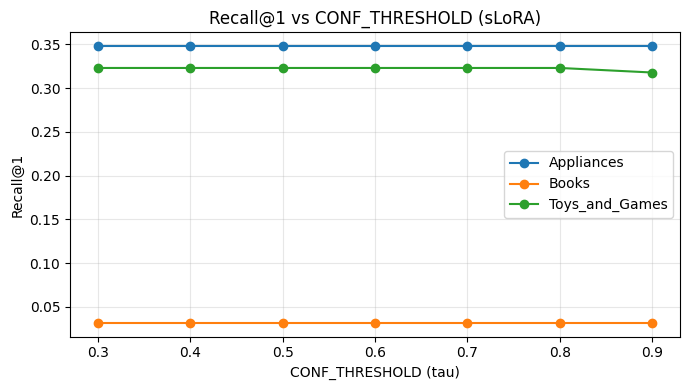

In [11]:
# Summarize sweeps: table + line plot
import matplotlib.pyplot as plt

if 'threshold_sweeps' not in globals() or not threshold_sweeps:
    raise RuntimeError("threshold_sweeps is empty. Run the per-category sweep cells first.")

rows = []
for cat, items in threshold_sweeps.items():
    rows.extend(items)

if not rows:
    raise RuntimeError("No sweep results found.")

# Table (sorted)
rows_sorted = sorted(rows, key=lambda r: (r['category'], r['tau']))
print("category\ttau\trecall\tvalidity")
for r in rows_sorted:
    print(f"{r['category']}\t{r['tau']:.1f}\t{r['recall']:.4f}\t{r['validity']:.4f}")

# Best tau per category (by recall)
best_by_cat = {}
for r in rows_sorted:
    key = r['category']
    if key not in best_by_cat or r['recall'] > best_by_cat[key]['recall']:
        best_by_cat[key] = r
print("\nBest tau per category (by recall):")
print("category\ttau\trecall\tvalidity")
for key in sorted(best_by_cat.keys()):
    r = best_by_cat[key]
    print(f"{r['category']}\t{r['tau']:.1f}\t{r['recall']:.4f}\t{r['validity']:.4f}")

# Line plot: recall vs tau
plt.figure(figsize=(7, 4))
for cat in sorted({r['category'] for r in rows_sorted}):
    sub = [r for r in rows_sorted if r['category'] == cat]
    taus = [r['tau'] for r in sub]
    recalls = [r['recall'] for r in sub]
    plt.plot(taus, recalls, marker='o', label=cat)

plt.title('Recall@1 vs CONF_THRESHOLD (sLoRA)')
plt.xlabel('CONF_THRESHOLD (tau)')
plt.ylabel('Recall@1')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()